In [1]:
from openpiv import windef # <---- see windef.py for details
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
import numpy as np
import pathlib
import importlib_resources
from time import time
import warnings
import cv2 as cv
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import sys
sys.path.append(r"D:\ESPCI\codes\multgridPIV")  # Add the folder containing the script to the Python path
#import windef_modified  # Import the script as a module
import openpiv.filters
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### When I am reading from ND2. I comment this line for now since I am getting same error in v with ND2 as with png/tiff
##im1 = ND2Reader('ten0.01_sam20230331_eco_sll2_1mm_FP_3um_0.03_t_2x_test001.nd2')
t1 = 23
t2 = 24
gauss_bg = 101
gauss_ns = 1
im1_t0 = tools.imread("../test20/t_23.png")#im1[t1]
im2_t0 = tools.imread('../test20/t_24.png')#im1[t2]
## Correcting for background and noise
im1_t0_fil = gaussian_filter(im1_t0/gaussian_filter(im1_t0, gauss_bg),gauss_ns)
im2_t0_fil = gaussian_filter(im2_t0/gaussian_filter(im2_t0, gauss_bg),gauss_ns)

### Importing the setting class from windef
settings = windef.PIVSettings()


In [3]:
'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
###settings.dynamic_masking_method = 'None'
###settings.dynamic_masking_threshold = 0.005
###settings.dynamic_masking_filter_size = 7
settings.roi = 'full'

settings.deformation_method = 'symmetric'

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation=False

settings.num_iterations = 1 #2 # select the number of PIV passes
# add the interroagtion window size for each pass.
# For the moment, it should be a power of 2
settings.windowsizes = ([64,32])#([64,32]) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = ([16])#([16,8]) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between two frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.min_max_u_disp = (-30, 30)
settings.min_max_v_disp = (-30, 30)
# The second filter is based on the global STD threshold
settings.std_threshold = 7  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
##settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
##settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
# settings.do_sig2noise_validation = False # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
##settings.sig2noise_threshold = 1.2
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4 #4
settings.filter_kernel_size = 1  # kernel size for the localmean method
##'Output options'
# Select if you want to save the plotted vectorfield: True or False
##settings.save_plot = True
# Choose wether you want to see the vectorfield or not :True or False
##settings.show_plot = True
##settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

In [4]:
x, y, u, v, flags = windef.simple_multipass(im1_t0_fil,im2_t0_fil,settings)
u /= settings.dt
v /= settings.dt

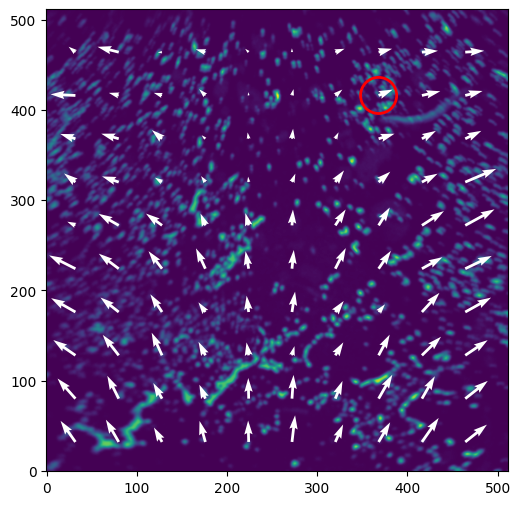

In [5]:
fig, axs = plt.subplots(1,1, figsize=(6,6))
axs.imshow(im1_t0_fil)
fig.gca().invert_yaxis()
#axs[0].imshow(np.dstack((scalevalues(fil_im1,0,100),scalevalues(fil_im2,0,100), np.zeros(imgray1.shape)))[...,[0,1,0]], origin = 'lower')
axs.quiver(x,y,u,v,color='white', scale = 0.05, scale_units='xy')
a = x[np.where(u==u[1,7])]#Adjust this to your desired x-coordinate
b = y[np.where(u==u[1,7])]  # Adjust this to your desired y-coordinate
radius = 20
circle = Circle((a, b), radius, fill=False, color='red', linewidth=2)
axs.add_patch(circle)

In [6]:
print ('the maximum and minim of u are {} and {}'.format(u.max(),u.min()))

the maximum and minim of u are 1.7181221258145882 and -1.4561565620749164


In [7]:
print ('the maximum and minim of v are {} and {}'.format(v.max(),v.min()))

the maximum and minim of v are 1.4776910767962832 and -0.018612163867175013


### The issue with above is the u displacement are reasonable and in the expected range. However, the v have wrong sign and also a wrong sense. The larger quiver should be on the top and pointing downwards. Besides, also the magnitudes are fishy if for example I add in real multigrid with multiple window size instead of 2 , the maximum and minim of v are 2.0496276329883063 and -0.028171378284373553 (for u not so drastic change)

## I try the extended_search_area_piv to compare

In [8]:
ws = 64  # Window size
ol = 16  # Overlap size
sas = 64  # Search area size
dt = 1

u, v, sig2noise = pyprocess.extended_search_area_piv(
    im1_t0_fil,
    im2_t0_fil,
    window_size=ws,
    overlap=ol,
    dt=dt,
    search_area_size=sas,
    sig2noise_method='peak2peak'
)

# Replace outliers in velocity fields
u_f, v_f = openpiv.filters.replace_outliers(u, v,flags = np.zeros((u.shape[0], u.shape[1])).astype('int16'), method='localmean', kernel_size=1)

# Get coordinates for plotting
x, y = pyprocess.get_coordinates(im1_t0_fil.shape, search_area_size=sas, overlap=ol)

In [9]:
print ('the maximum and minim of u from ESA_PIV are {} and {}'.format(u_f.max(),u_f.min()))

the maximum and minim of u from ESA_PIV are 1.7181221258145882 and -1.4561565620749164


In [10]:
print ('the maximum and minim of v from ESA_PIV are {} and {}'.format(v_f.max(),v_f.min()))

the maximum and minim of v from ESA_PIV are -0.0635898851482466 and -1.4776910767962832


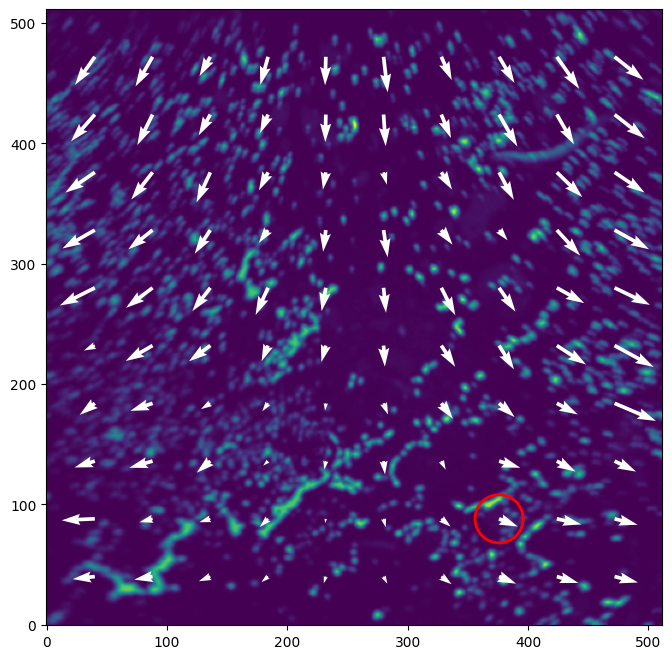

In [11]:
fig, axs = plt.subplots(1,1, figsize=(8,8))
axs.imshow(im1_t0_fil)
fig.gca().invert_yaxis()
axs.quiver(x,y,u_f,v_f,color='white', scale = 0.05, scale_units='xy')
a = x[np.where(u==u[1,7])]#Adjust this to your desired x-coordinate
b = y[np.where(u==u[1,7])]  # Adjust this to your desired y-coordinate
radius = 20
circle = Circle((a, b), radius, fill=False, color='red', linewidth=2)
axs.add_patch(circle)

## This corresponds to the more precise measurement expected from simple_multipass.
However, If I do certain operations such as reversing the 'y' output and taking the negative of the 'v' output, the results concur

In [12]:
x, y, u, v, flags = windef.simple_multipass(im1_t0_fil,im2_t0_fil,settings)
u /= settings.dt
v /= settings.dt

y = y[::-1,:]
v = -v

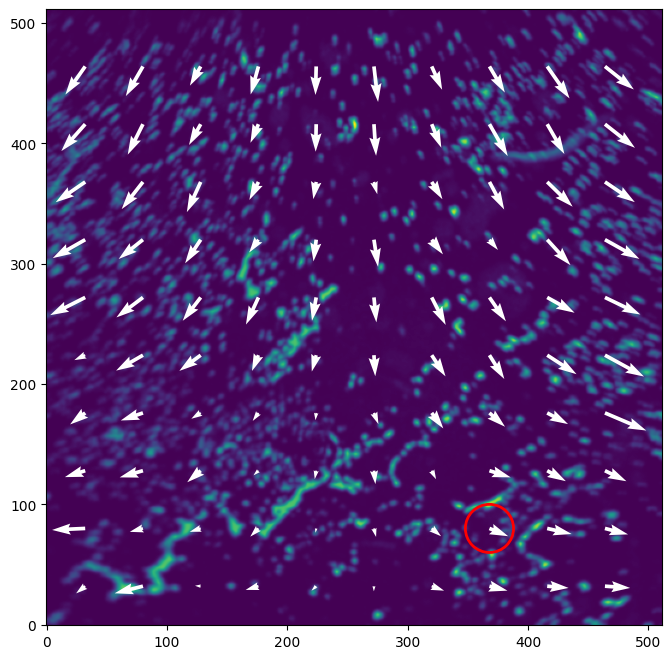

In [13]:
fig, axs = plt.subplots(1,1, figsize=(8,8))
axs.imshow(im1_t0_fil)
fig.gca().invert_yaxis()
#axs[0].imshow(np.dstack((scalevalues(fil_im1,0,100),scalevalues(fil_im2,0,100), np.zeros(imgray1.shape)))[...,[0,1,0]], origin = 'lower')
axs.quiver(x,y,u,v,color='white', scale = 0.05, scale_units='xy')
a = x[np.where(u==u[1,7])]#Adjust this to your desired x-coordinate
b = y[np.where(u==u[1,7])]  # Adjust this to your desired y-coordinate
radius = 20
circle = Circle((a, b), radius, fill=False, color='red', linewidth=2)
axs.add_patch(circle)